# Prstni odtisi (angl. Fingerprints)

Za namen analize kemijskih struktur je navadno potrebno te spremeniti v ustrezen vektorski zapis. Najenostavnejši in najbolj naraven zapis za računalnik je binarni vektor, kar pomeni, da je vsak element vektorja "0" ali "1". V kontekstu kemoinformatike temu vektorju rečemo prstni odtis molekule. Prstni odtisi se delijo na tri skupine, glede na kako so zgrajeni.

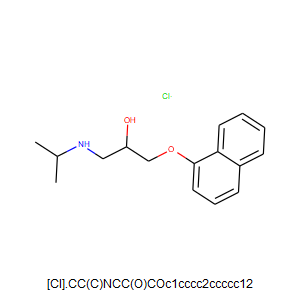

In [64]:
import numpy as np
from rdkit import DataStructs, Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Fingerprints import FingerprintMols
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, '../code')
import cheauder_utils

plt.rcParams['figure.figsize'] = [10, 10]

def fp_to_numpy(X):
    Xfinger = list()
    for x in X:
        arr = np.zeros((0,))
        DataStructs.ConvertToNumpyArray(x, arr)
        Xfinger.append(arr)
    return np.array(Xfinger)

smiles, y, label = cheauder_utils.read_data('../data/BBBP.csv', col_smiles=3, col_target=2, delimiter=',')
label = 'Blood-brain barrier\npenetration'
np.random.seed(42)
n = 100
smiles = np.array(smiles[:n])
y = y[:n]
mols = [Chem.MolFromSmiles(smile) for smile in smiles if Chem.MolFromSmiles(smile) is not None]
y = np.array([yi for i,yi in enumerate(y) if Chem.MolFromSmiles(smiles[i]) is not None])
#https://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-fingerprints

tmp = AllChem.Compute2DCoords(mols[0])

Draw.MolsToGridImage([mols[0]], 1,(300,300) , legends=[smiles[0]])

## Topološki prstni odtisi
Topološki prstni odtisi so zgrajeni tako, da se najprej poiščejo vse linearne poti do določene dolžine za vsak ne-vodikov atom v molekuli. Vsaka ta pot je potem uporabljena kot seme za generator psevdonaključnih števil, katerega izhod me množica bitov. Te biti so dodani prstnemu odtisu po principu disjunkcije. Razlog je, da lahko različne poti uporabijo isti bit, vendar ker se uporablja množico bitov za vsako pot, je verjetnost celotnega prekrivanja dveh poti zanemarljivo majhna.
Spodaj je prikazan prstni odtis molekule '\[Cl\].CC(C)NCC(O)COc1cccc2ccccc12' v zapisu SMILES in vektorska vložitev 100 molekul iz datoteke BBBP.csv. Algoritem je RDKit-ova implementacija Daylight prstnega odtisa. 

0000000000000000000010000101000000000000000010001000100010000101011000100010010000000000000000000000100100000101100000000001001000001000000001000000000000000000110000100010010000001000000100000010000000000000110000010000000100001100000000000010000000000000000001001001000000000010010000000000001100000000010010010000010001000000001100000010000000100000010000000000000100000000000000000000001000000000000000000000110000000000100010001001010011111000000000000100010000000001001001000011000000001000001000110000000000000000000101000000000010000000000001000000000100100100000010000010010000000000100010010101000010100000000100000000100000000000000010011010100000000000000000000000010000000100000000100000000000010100000000010001000001000000011000000000010000100000000000000000000000100100000000001010000100000000110000010000000000000100001001000010000001000000000000000100000000000000000000100000000000000000000000000000000001000000010001000000000000100001101000110000000000000000000000000000000000000000

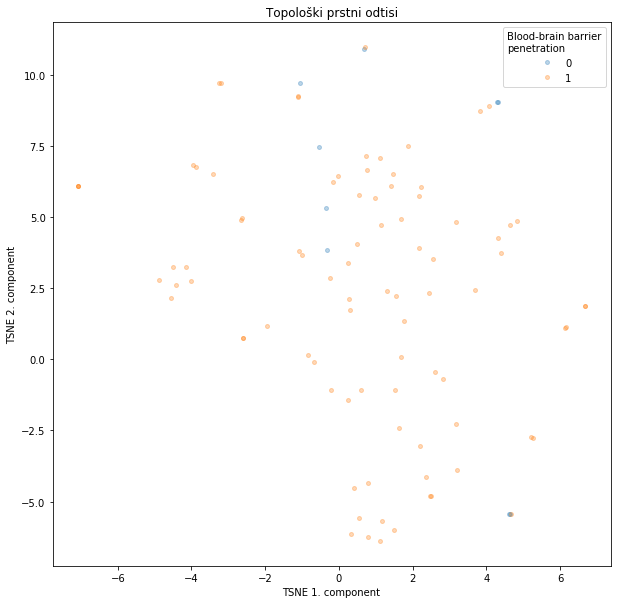

In [65]:
# topological
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.rdmolops import RDKFingerprint

fps_top = [Chem.RDKFingerprint(x) for x in mols]
print(fps_top[0].ToBitString())
fps_top = fp_to_numpy(fps_top)

cheauder_utils.plot_tsne_classification(fps_top, y, 'Topološki prstni odtisi', label)

## Krožni prstni odtisi
Krožni prstni odtisi so podobni topološkim. Za vsak ne-vodikov atom v strukturi vzamemo ta atom in njegovih "n" sosedov kot posamezno pod/strukturo in jo zakodiramo enako kot pri topološkem. Število sosedov je ponavadi med 0 in 3.
RDKit ima implementacijo krožnega prstnega odtisa, ki temelji na Morganovem algoritmu, ki omogoča poljubno izbiro števila sosedov.

0100000010000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000100000000000000000000100000000000000000000000000000100000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000100000000000000000000000000000000000010000000000000000000000000000000001010000000010000000000000000000000000000000000000000010000000000000000000000001000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000

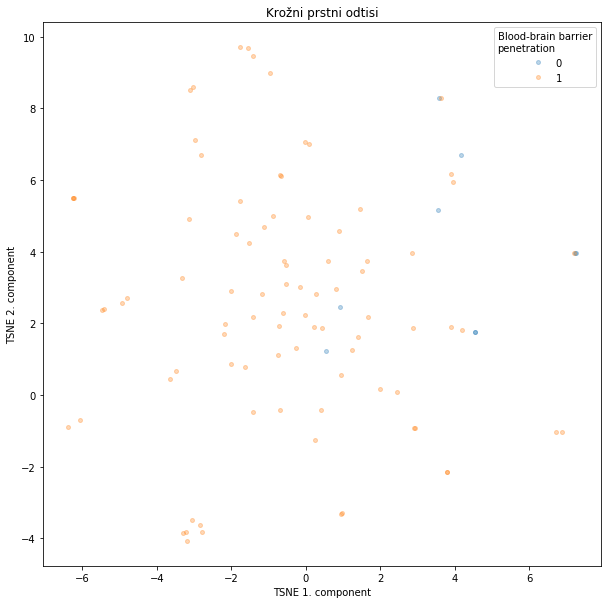

In [66]:
n = 3
fps_cir = [Chem.AllChem.GetMorganFingerprintAsBitVect(x, n) for x in mols]
print(fps_cir[0].ToBitString())
fps_cir = fp_to_numpy(fps_cir)

cheauder_utils.plot_tsne_classification(fps_cir, y, 'Krožni prstni odtisi', label)

## Podstrukturni prstni odtisi
Pri podstrukturnih prstnih odtisih je potrebno imeti v naprej definiran slovar podstruktur oz. fragmentov molekule. Posamezne vrednosti v dobljenem vektorju prikazujejo prisotnost ali odsotnost te podstrukture. Dolžina vektorja je torej enaka številu podstruktur v slovarju.
Spodaj je prikazan primer MACCS prstnega odtisa, ki ima 166 v naprej definiranih podstruktur.

00000000000000000000000000000000000000000000000000000010000000000000000010100000001000000010000101001101110001000100100000000111000110100011000101000101110111111111111


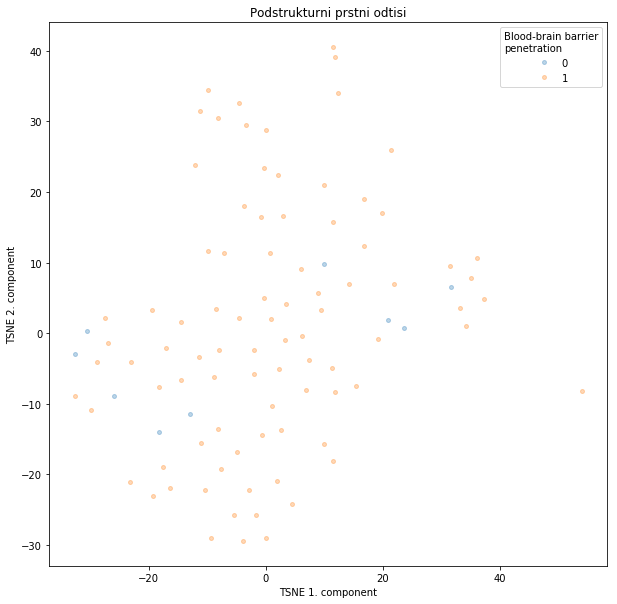

In [67]:
fps_sub = [Chem.MACCSkeys.FingerprintMol(x) for x in mols]
print(fps_sub[0].ToBitString())

cheauder_utils.plot_tsne_classification(fps_sub, y, 'Podstrukturni prstni odtisi', label)

## Prstni odtisi, ki jih še RDKit podpira
Knjižnica RDKit omogoča tudi enostavno iskanje skupnih fragmentov množice molekul. Kot so Avalon, Atom Paris, Topological Torsion, Patter, Extendend Reduced Graphs in 2D Pharamacophore. Način uporabe se pri vseh podobna.

0100000010000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000100000000000000000000100000000000000000000000000000100000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000100000000000000000000000000000000000010000000000000000000000000000000001010000000010000000000000000000000000000000000000000010000000000000000000000001000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000

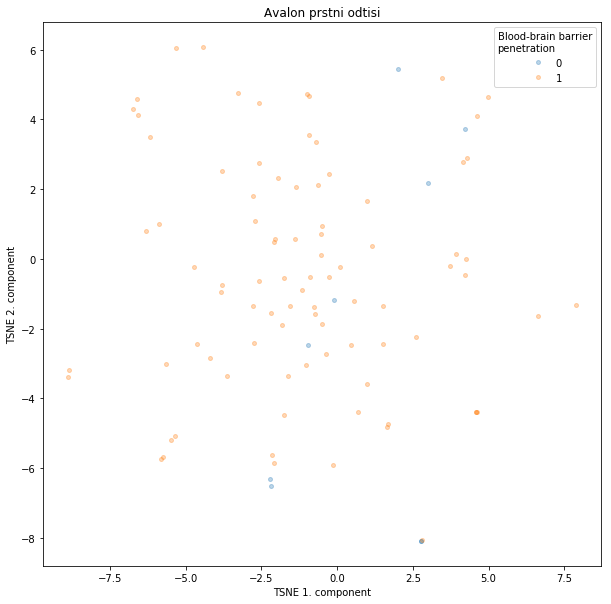

In [68]:
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

fps_ava = [Chem.AllChem.GetMorganFingerprintAsBitVect(x, n) for x in mols]
print(fps_ava[0].ToBitString())
fps_ava = fp_to_numpy(fps_ava)

cheauder_utils.plot_tsne_classification(fps_ava, y, 'Avalon prstni odtisi', label)

## Iskanje skupnih fragmentov molekul
Knjižnica RDKit omogoča tudi enostavno iskanje skupnih fragmentov množice molekul. 

In [78]:
from rdkit.Chem import rdFMCS

mol1 = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")
mol2 = Chem.MolFromSmiles("CC(C)CCCCCC(=O)NCC1=CC(=C(C=C1)O)OC")
mol3 = Chem.MolFromSmiles("c1(C=O)cc(OC)c(O)cc1")
mols = [mol1,mol2,mol3]

mcs = rdFMCS.FindMCS(mols)

nms = [Chem.Mol(x) for x in mols]
def getMCSSmiles(mol,mcs):
    mcsp = Chem.MolFromSmarts(mcs.smartsString)
    match = mol.GetSubstructMatch(mcsp)
    return Chem.MolFragmentToSmiles(mol,atomsToUse=match,
                                    isomericSmiles=True,
                                    canonical=True)
print(getMCSSmiles(nms[1],mcs))
#Chem.MolToSmiles(Chem.MolFromSmarts(mcs.smartsString))

COc1cc(C)ccc1O
